# Interactive loading of PHEONIX NewEra synthetic stellar spectra
Model grids published in The NewEra model grid ([Hauschildt _et al_., 2025](https://ui.adsabs.harvard.edu/abs/2025arXiv250417597H))

Data and sample code published at [DOI: 10.25592/uhhfdm.16727](https://doi.org/10.25592/uhhfdm.17156)

In [1]:
import numpy as np
#%matplotlib widget 
import matplotlib.pyplot as plt
import astropy.units as u

from deblib.constants import c
from libs.neweraspectra import parse_lr_spectra_file

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


### Parse the SPECTRA text file
The data files are in the [PHOENIX-NewEra-LowRes-SPECTRA.tar.gz](https://www.fdr.uni-hamburg.de/record/17156/files/PHOENIX-NewEra-LowRes-SPECTRA.tar.gz?download=1)
archive published at [DOI: 10.25592/uhhfdm.16727](https://doi.org/10.25592/uhhfdm.17156).

> **Note**: the archive is ~17.7 GB is size as it contains files for various combinations of Z and alpha.

Each file contains a range of spectra for combinations of $T_{\rm eff}$ and $\log{g}$
over the wavelength range $250$ to $2500\,{\rm nm}$ in bins of $0.01\,{\rm nm}$.

Parse the text data file into a `numpy` structured array. At this point we are also
rescaling the wavelength from ${\rm nm}$ to $\mu{\rm m}$.

In [3]:
# These are prepared "low res" spectra covering the range 250 to 2500 nm in 0.01 nm steps.
Z = 0.0
table = parse_lr_spectra_file(f'libs/data/newera/PHOENIX-NewEra-LowRes-SPECTRA.Z-{Z:.1f}.txt', bin_fluxes=True)

In [4]:
distinct_teffs = np.unique(table["teff"])
distinct_loggs = np.unique(table["logg"])
print("Distinct Teff:", sorted(distinct_teffs))
print("Distinct logg:", sorted(distinct_loggs))

Distinct Teff: [2300.0, 2400.0, 2500.0, 2600.0, 2700.0, 2800.0, 2900.0, 3000.0, 3100.0, 3200.0, 3300.0, 3350.0, 3400.0, 3500.0, 3600.0, 3700.0, 3800.0, 3900.0, 4000.0, 4100.0, 4200.0, 4300.0, 4400.0, 4500.0, 4600.0, 4700.0, 4800.0, 4900.0, 5000.0, 5100.0, 5200.0, 5300.0, 5400.0, 5500.0, 5600.0, 5700.0, 5770.0, 5800.0, 5900.0, 6000.0, 6050.0, 6060.0, 6100.0, 6200.0, 6300.0, 6400.0, 6500.0, 6600.0, 6700.0, 6800.0, 6900.0, 7000.0, 7200.0, 7400.0, 7600.0, 7800.0, 8000.0, 8200.0, 8400.0, 8600.0, 8800.0, 9000.0, 9200.0, 9400.0, 9600.0, 9800.0, 10000.0, 10200.0, 10400.0, 10600.0, 10800.0, 11000.0, 11200.0, 11400.0, 11600.0, 11800.0, 12000.0]
Distinct logg: [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.15, 4.44, 4.5, 4.95, 5.0, 5.5, 6.0]


### Query the Spectra table

In [12]:
target_teff = 5770  # K
target_logg = 4.4

print(f"Looking for spectra for T_eff = {target_teff} K and logg = {target_logg}")

# TODO: sort by "closeness"
row = table[np.argmin(np.abs(table["index"] - (target_teff + target_logg)))]
lambdas = np.linspace(row["lam_from"], row["lam_to"], row["lam_steps"])[::5]
fluxes = row["flux_interp"](c * 1e6 / lambdas)


Looking for spectra for T_eff = 5770 K and logg = 4.4


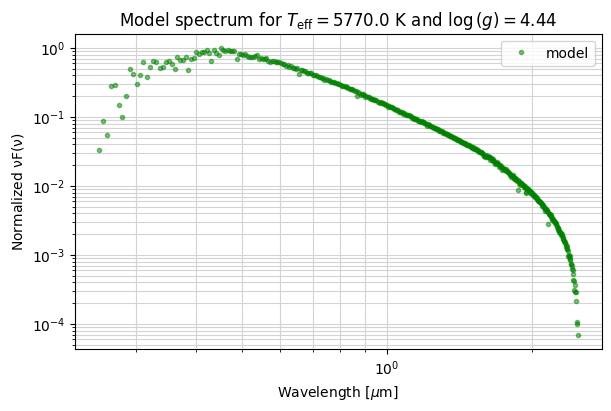

In [13]:
vfv = fluxes * c / (lambdas * 1e6)
norm_vfv = (vfv - vfv.min()) / (vfv.max() - vfv.min())

title = f"Model spectrum for $T_{{\\rm eff}}={row['teff']}$ K and $\\log{{(g)}}={row['logg']}$"
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.loglog(lambdas, norm_vfv, ".g", alpha=0.5, label="model")
ax.set(title=title, xlabel=r"Wavelength [$\mu$m]", ylabel=r"Normalized ${\rm \nu F(\nu)}$")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)